In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [200]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder


#train and test data directory
train_data_dir = "F:/work/spine/Classification_Data/train" 

val_data_dir = "F:/work/spine/Classification_Data/val"


#load the train and test data
train_data = ImageFolder(train_data_dir,transform = T.Compose([
     T.RandomRotation(10),
     # T.RandomAffine(0, translate=(0.1, 0.1)),
     T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    # T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.5),
    T.Resize((224, 224)),
#     T.CenterCrop(224),
    T.RandomApply([T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

val_data =  ImageFolder(val_data_dir,transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

In [201]:
print("Follwing classes are there : \n",train_data.classes)

Follwing classes are there : 
 ['Fracture', 'Not_Fracture']


In [171]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 16
# val_size = 2000
# train_size = len(dataset) - val_size 

# train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

Length of Train Data : 10486
Length of Validation Data : 2996


In [8]:
%cd F:\PythonEn\Grad-CAM\pytorch-grad-cam

F:\PythonEn\Grad-CAM\pytorch-grad-cam


In [7]:
import torch.nn as nn
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(200704,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )
    
    def forward(self, xb):
        return self.network(xb)
    

In [9]:
model= Classification()
model.load_state_dict(torch.load("F:/work/PythonEn/Code/Classification_spine/modelcnn30_spine.pt")) # load pre-trained weights
# model = torch.load("F:/PythonEn/Grad-CAM/hd_resnet.pt")
model.eval()

Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predicted_labels = []
true_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()  # Set the model to evaluation mode

for data, target in tqdm(val_dl):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():  # Turn off gradient computation
        output = model(data)
        _, predictions = torch.max(output, 1)
    
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    targets = target.cpu().numpy()

    # Append predictions and targets to the lists
    predicted_labels.extend(predictions)
    true_labels.extend(targets)
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [02:13<00:00,  1.42s/it]

Accuracy: 0.979305740987984
Precision: 0.9871099050203528
Recall: 0.9712950600801068
F1-score: 0.9791386271870794


In [50]:
val_accuracy, val_precision, val_recall, val_f1 = evaluate_metrics(model, val_dl)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Accuracy: 0.9793
Validation Precision: 0.9871
Validation Recall: 0.9713
Validation F1 Score: 0.9791


In [54]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in val_dl:
        images, labels = batch
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())


In [55]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

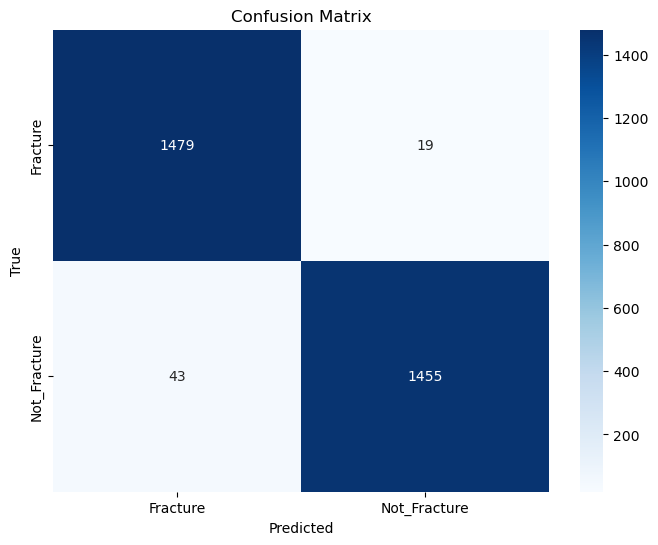

In [56]:
class_names = ['Fracture', 'Not_Fracture']  # Replace with your class names

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Grad_Cam

In [2]:
%cd F:\PythonEn\Grad-CAM\pytorch-grad-cam

F:\PythonEn\Grad-CAM\pytorch-grad-cam


In [8]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
import torch.nn as nn
import argparse
import os
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise
)
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [78]:
# model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=False)
model= Classification()
model.load_state_dict(torch.load("F:/work/PythonEn/Code/Spine_Project/Grad-CAM/cnn40_spine.pt")) # load pre-trained weights
# model = torch.load("F:/PythonEn/Grad-CAM/hd_resnet.pt")
model.eval().to(device)

img = Image.open("F:/work/PythonEn/Code/Spine_Project/Grad-CAM/f5.png")
img = img.convert("RGB")
img_tensor = transforms.ToTensor()(img)
img_tensor = transforms.Resize((224, 224))(img_tensor)
img_tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(img_tensor)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [15]:
print(model)

Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [474]:
with torch.no_grad():
    output = model(img_tensor)  # Forward pass
    probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Apply softmax to get class probabilities

# Get the predicted class index
predicted_class_idx = torch.argmax(probabilities).item()

print("Predicted class index:", predicted_class_idx)
print("Class probabilities:", probabilities)

Predicted class index: 0
Class probabilities: tensor([0.9958, 0.0042])


In [475]:
# with torch.no_grad():
#     output = model(img_tensor.unsqueeze(0))
#     i = output.argmax(dim=1).item()

In [476]:
target_layers = [model.network[12]]
target_layers

[Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [477]:
# %cd F:\PythonEn\Grad-CAM\pytorch-grad-cam

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [479]:
cam = XGradCAM(model=model, target_layers=target_layers, use_cuda= False)

In [480]:
targets = [ClassifierOutputTarget(0)]

In [481]:
img = Image.open("F:/PythonEn/Grad-CAM/f5.png")
img = img.convert("RGB")
rgb_img = transforms.ToTensor()(img)
rgb_img = transforms.Resize((224, 224))(rgb_img)
rgb_img = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(rgb_img)
rgb_img = np.float32(rgb_img) / 255.0
rgb_img = np.transpose(rgb_img, (2, 1, 0))
rgb_img.shape

(224, 224, 3)

In [482]:
grayscale_cam = cam(input_tensor=img_tensor, targets =targets)

In [483]:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

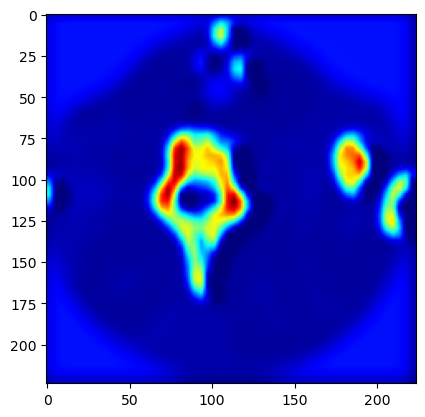

In [484]:
# image_array = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)
aug_smooth=True
# # # Show image using plt.imshow()
# plt.imshow(image_array)
plt.imshow(visualization)

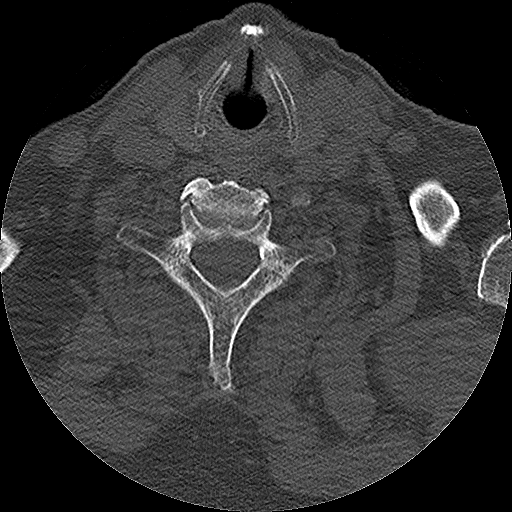

In [485]:
img = Image.open("F:/PythonEn/Grad-CAM/f5.png")
img = img.convert("RGB")
img

In [16]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image


image = "F:/PythonEn/Grad-CAM/f5.png"
img = np.array(Image.open(image))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
img = np.stack((img,) * 3, axis=-1)
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


with torch.no_grad():
    output = model(input_tensor)
    pred = output.argmax(dim=1).item()

result_dict = {0: "Fracture", 1: "Not_Fracture"}
prediction = result_dict.get(pred, "Unknown")

print("Prediction:", prediction)

Prediction: Not_Fracture


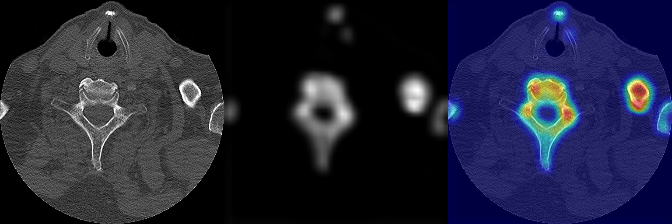

In [490]:
targets = [ClassifierOutputTarget(pred)]

target_layers = [model.network[12]]

with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam, cam_image))
Image.fromarray(images)

The confidence increase percent: 0.22417902946472168
The visualization of the pertubated image for the metric:


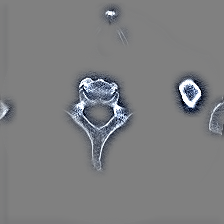

In [491]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(pred)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: 0.0021683573722839355
The visualization of the pertubated image for the metric:


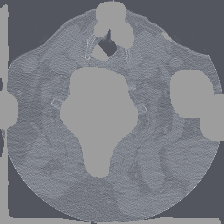

In [492]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: -0.7874423265457153
The visualization of the pertubated image for the metric:


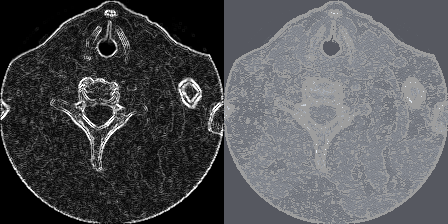

In [493]:
from pytorch_grad_cam.sobel_cam import sobel_cam

sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, 75)

cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, [thresholded_cam], targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
sobel_cam_rgb = cv2.merge([sobel_cam_grayscale, sobel_cam_grayscale, sobel_cam_grayscale])
Image.fromarray(np.hstack((sobel_cam_rgb, visualization)))

The confidence increase when removing 25% of the image: -0.40747350454330444
The confidence increase when removing 10% of the image: -0.9628418684005737
The visualizations:


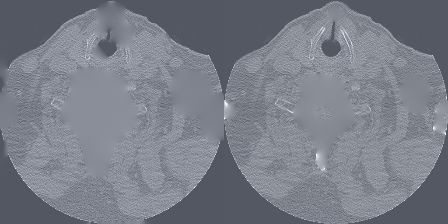

In [494]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase when removing 25% of the image: {score}")

cam_metric = ROADMostRelevantFirst(percentile=90)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization_10 = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization_10 = deprocess_image(visualization_10)
print(f"The confidence increase when removing 10% of the image: {score}")
print("The visualizations:")
Image.fromarray(np.hstack((visualization, visualization_10)))

In [100]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage
cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)
print(f"The average confidence increase with ROAD accross 4 thresholds: {scores[0]}")
scores = cam_metric(input_tensor, [sobel_cam_grayscale], targets, model)
print(f"The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: {scores[0]}")

The average confidence increase with ROAD accross 4 thresholds: 0.3613109886646271
The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: 0.25152787566185


# YOLO

In [317]:
from ultralytics import YOLO

In [348]:
yolo = YOLO("F:/work/PythonEn/Grad-CAM/last.pt")

In [350]:
!yolo task=detect mode = predict model = F:/work/PythonEn/Grad-CAM/last.pt show=True conf = 0.25 source = F:/work/PythonEn/Grad-CAM/t1.png

Ultralytics YOLOv8.0.201  Python-3.10.13 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8187MiB)
Model summary (fused): 268 layers, 43612005 parameters, 0 gradients, 164.8 GFLOPs

image 1/1 F:\work\PythonEn\Grad-CAM\t1.png: 512x512 1 C2, 257.5ms
Speed: 1.0ms preprocess, 257.5ms inference, 55.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict9
 Learn more at https://docs.ultralytics.com/modes/predict


In [274]:
im = "F:/work/PythonEn/Grad-CAM/2.png"

In [351]:
img_yolo = cv2.resize(img, (512, 512))
input_tensor_yolo = torch.from_numpy(img_yolo).permute(2, 0, 1).unsqueeze(0)

In [354]:
print("Classification Prediction:", prediction)
with torch.no_grad():
    output_yolo = yolo(input_tensor_yolo)

Classification Prediction: Fracture


0: 512x512 1 C2, 249.0ms
Speed: 2.0ms preprocess, 249.0ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 512)


In [353]:
print("Classification Prediction:", prediction)
print("YOLO Results:", output_yolo)

Classification Prediction: Fracture
YOLO Results: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'C1', 1: 'C2', 2: 'C3', 3: 'C4', 4: 'C5', 5: 'C6', 6: 'C7'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
     

In [312]:
# Print the classification prediction
print("Classification Prediction:", prediction)

# Print the YOLO results
print("YOLO Results:")
for result in output_yolo:
    print(result)

Classification Prediction: Fracture
YOLO Results:
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'C1', 1: 'C2', 2: 'C3', 3: 'C4', 4: 'C5', 5: 'C6', 6: 'C7'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
      